In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import cloudpickle
import dask.dataframe as dd

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [27]:
session_info = {'date': "10_02_2024",
                'genotype_dir': 'EPG_jGCaMP7b_VK05',
                'fly': 'fly4',
                'session': 'mianserin_dark-004',
                'fictrac_scan_num':4,
                'fictrac_dat_file' : 'fictrac-20240210_130730.dat',
                'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)',
                'ecl date': '2/3-4/2024',
                'notes': ''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')

In [28]:
gd = session_info['genotype_dir']
d = session_info['date']
f = session_info['fly']
s = session_info['session']
outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
pp = st2p.preprocessing.EBImagingSession.from_file(outdir)

In [29]:
pp.session_info['fictrac_dat_file'] = session_info['fictrac_dat_file']
pp.fictrac_base_dir = fictrac_folder
pp.fictrac_dir = pp.fictrac_base_dir.joinpath(f'{gd}/{d}')
pp.fictrac_pkl_path = pp.fictrac_dir.as_posix() + f"/{f}_scan{session_info['fictrac_scan_num']}.pkl"
pp.fictrac_path = pp.fictrac_dir.joinpath(session_info['fictrac_dat_file'])

print(pp.fictrac_path,pp.fictrac_pkl_path)

/media/mplitt/SSD_storage/fictrac_folder/EPG_jGCaMP7b_VK05/10_02_2024/fictrac-20240210_130730.dat /media/mplitt/SSD_storage/fictrac_folder/EPG_jGCaMP7b_VK05/10_02_2024/fly4_scan4.pkl


In [30]:
pp.session_info

{'date': '10_02_2024',
 'genotype_dir': 'EPG_jGCaMP7b_VK05',
 'fly': 'fly4',
 'session': 'mianserin_dark-004',
 'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)',
 'ecl date': '2/3-4/2024',
 'notes': '50 microM mianserin',
 'fictrac_dat_file': 'fictrac-20240210_130730.dat'}

In [31]:
pp.align_fictrac()

In [32]:
pp.fictrac_aligned['movement speed'].iloc[:100]

0     0.012515
1     0.007484
2     0.005754
3     0.018181
4     0.005131
        ...   
95    0.006932
96    0.014238
97    0.005513
98    0.005261
99    0.018444
Name: movement speed, Length: 100, dtype: float64

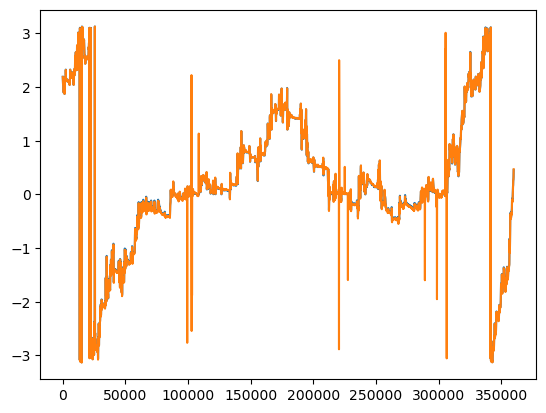

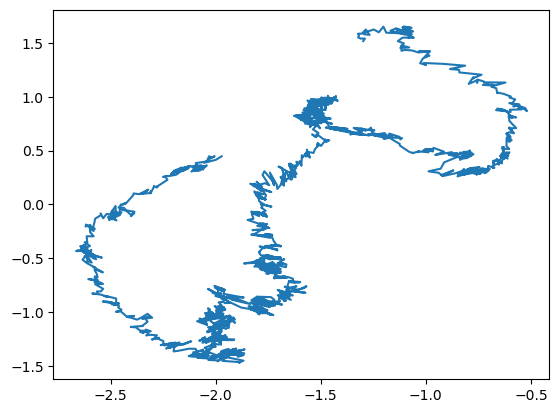

In [33]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])

fig, ax = plt.subplots()
ax.plot(pp.fictrac_aligned['integ x (lab)'].iloc[inds], pp.fictrac_aligned['integ y (lab)'].iloc[inds])

In [34]:
pp.save()

In [28]:
names = ( 'col',
         'd rot x (cam)', 'd rot y (cam)', 'd rot z (cam)', 
         'd rot err (cam)', 
         'd rot x (lab)', 'd rot y (lab)', 'd rot z (lab)', 
         'abs rot x (cam)', 'abs rot y (cam)', 'abs rot z (cam)',
         'abs rot x (lab)', 'abs rot y (lab)', 'abs rot z (lab)',
         'integ x (lab)', 'integ y (lab)', 
         'integ heading (lab)', 
         'movement dir (lab)',
         'movement speed',
         'integ forward',
         'integ side',
         'timestamp',
         'seq counter',
         'd timestamp',
         'alt. timestamp')

In [29]:



# pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
#                                          bruker_base_dir = bruker_folder,
#                                          fictrac_base_dir = fictrac_folder)

In [30]:
fictrac_path = fictrac_folder / session_info['genotype_dir'] / session_info['date'] / 'fictrac-20240205_163016.dat'

In [31]:
df = pd.read_csv(fictrac_path, names = names)

In [32]:
df.shape

(1268845, 25)

In [33]:
df['timestamp'].iloc[1000:2000]-df['timestamp'].iloc[1000]

1000    0.000000e+00
1001    2.125800e+06
1002    4.251600e+06
1003    6.378300e+06
1004    8.504100e+06
            ...     
1995    2.115418e+09
1996    2.117544e+09
1997    2.119670e+09
1998    2.121796e+09
1999    2.123922e+09
Name: timestamp, Length: 1000, dtype: float64

In [34]:
ft_scan_info_path = fictrac_folder / session_info['genotype_dir'] / session_info['date'] / f'{f}_scan0.pkl'
with open(ft_scan_info_path, 'rb') as file:
    ft_scan_info = cloudpickle.load(file)
    

In [10]:
ft_scan_info


{'start': [450501],
 'opto': [],
 'abort': [618965],
 'start_trig_falling_edge': []}

In [11]:
# start_ind = df['col']==ft_scan_info['start'][0]
start_ind = df.loc[df['col']==ft_scan_info['start'][0]].index[0]
# print(_start)
print(start_ind)

450501


In [12]:
df_vr = pd.read_csv(pp.voltage_recording_path)

In [13]:
df_vr.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

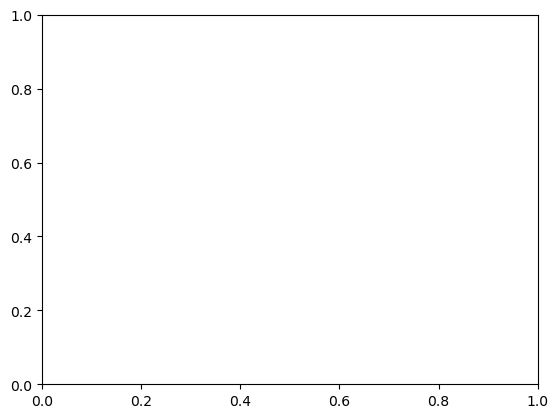

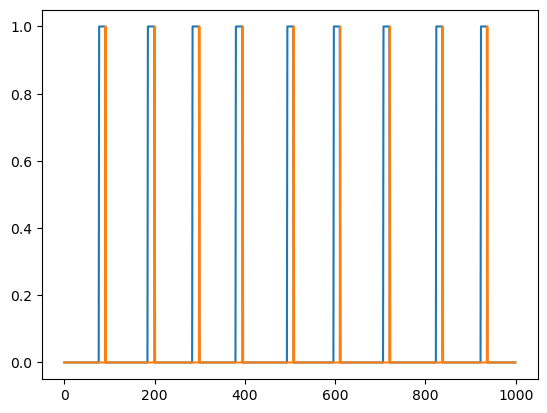

In [14]:
fig, ax = plt.subplots()
frame_proc = 1*(df_vr[ ' FicTrac Frame Proc.']>3)

# ax.plot(df_vr[ ' Start Trigger'].compute().iloc[:int(1E3)])
# ax.plot(df_vr[' FicTrac Frame Proc.'].compute().iloc[:int(1E3)] )

fig, ax= plt.subplots()
ax.plot(frame_proc.iloc[:1000])
frame_proc_redge = np.ediff1d(frame_proc, to_begin=0)<0
ax.plot(frame_proc_redge[:1000])

In [15]:
print(frame_proc_redge[:200])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [16]:
n_frames = frame_proc_redge.sum()
print(n_frames)

169359


In [17]:
df_vr = df_vr.loc[frame_proc_redge,:]
df_vr.shape

(169359, 9)

In [18]:
df_scan = df.iloc[start_ind:start_ind+n_frames]

In [19]:
df_scan.head

<bound method NDFrame.head of            col  d rot x (cam)  d rot y (cam)  d rot z (cam)  d rot err (cam)  \
450501  450501      -0.019281      -0.009369      -0.009890      5323.684211   
450502  450502       0.005685      -0.004950       0.005589      4848.355263   
450503  450503       0.005069       0.000224      -0.008038      4468.092105   
450504  450504       0.005211       0.000462      -0.007345      4848.355263   
450505  450505       0.005181       0.000383      -0.007293      5038.486842   
...        ...            ...            ...            ...              ...   
619855  619855      -0.000480      -0.000356       0.001651      2947.039474   
619856  619856      -0.011246      -0.000203       0.009254      3232.236842   
619857  619857       0.012356       0.000801      -0.010292      3137.171053   
619858  619858       0.001550      -0.003242      -0.003346      3137.171053   
619859  619859       0.002405      -0.002848      -0.003852      3232.236842   

        d

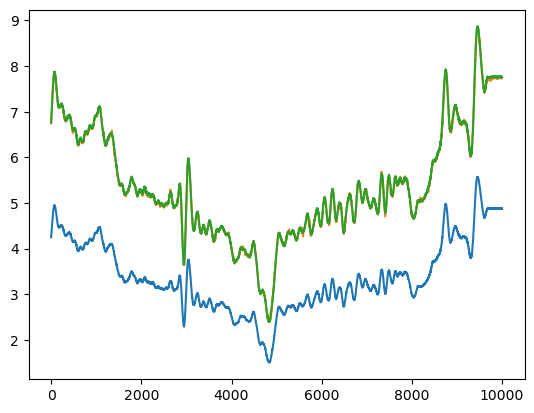

In [20]:
fig, ax= plt.subplots()
ax.plot(df_scan['col'].iloc[10000:20000]-df_scan['col'].iloc[10000], df_scan['integ heading (lab)'].iloc[10000:20000])
ax.plot(df_vr[' Heading'].iloc[10000:20000].to_numpy())
ax.plot(df_scan['col'].iloc[10000:20000]-df_scan['col'].iloc[10000], df_scan['integ heading (lab)'].iloc[10000:20000]/2/np.pi*10)

In [21]:
df_vr.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

In [22]:
df_scan.insert(1, 'Time(ms)', df_vr.loc[:, 'Time(ms)'].to_list())
# df_scan['Time(ms)']=df_vr.loc[:,'Time(ms)'].to_list()

In [23]:
df_scan.loc[:,'Time(ms)'].iloc[:10]

450501     1.82
450502     4.00
450503     5.98
450504     7.90
450505    10.16
450506    12.22
450507    14.42
450508    16.76
450509    18.74
450510    20.92
Name: Time(ms), dtype: float64